In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import os
import glob
import pickle
import jax
import jax.numpy as jnp
import bayes3d as b
import genjax
import matplotlib.pyplot as plt

In [7]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7001/static/


In [8]:
with open('data.pkl', 'rb') as f:
    data = pickle.load(f)

In [9]:
camera_image_1 = data["init"][0]
categories_on_table = data["init"][1]
target_category = data["init"][2]
table_info = data["init"][3] # table pose and dimensions
n_objects = 5

In [10]:
table_info

(((0.475, 0.0, -0.015), (0.0, 0.0, 0.0, 1.0)), 0.75, 1.22, 0.03)

In [11]:
X_WT = b.t3d.pybullet_pose_to_transform(table_info[0])
# transform_from_pos(jnp.array(table_info[0][0]))
X_WT

Array([[ 1.   ,  0.   ,  0.   ,  0.475],
       [ 0.   ,  1.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  1.   , -0.015],
       [ 0.   ,  0.   ,  0.   ,  1.   ]], dtype=float32)

In [12]:
X_WC = b.t3d.pybullet_pose_to_transform(camera_image_1["camera_pose"])

In [13]:
X_CT = b.t3d.inverse_pose(X_WC) @ X_WT
X_CT

Array([[-5.4998524e-02, -9.9848646e-01,  3.3535539e-08,  2.4800077e-02],
       [-7.2509176e-01,  3.9939445e-02, -6.8749315e-01,  1.8637428e-01],
       [ 6.8645257e-01, -3.7811164e-02, -7.2619092e-01,  6.0053611e-01],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  1.0000000e+00]],      dtype=float32)

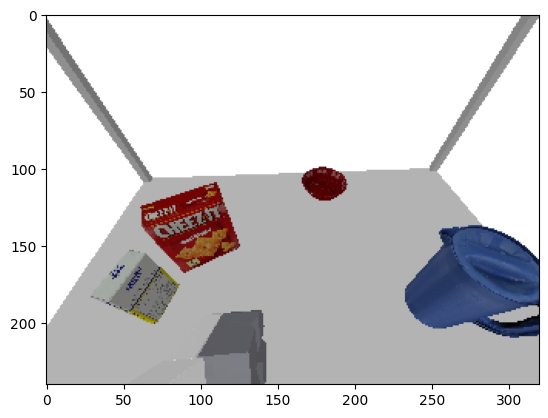

In [14]:
plt.imshow(camera_image_1["rgbPixels"])

In [15]:
def image_to_rgbd(camera_image_1):
    K = camera_image_1['camera_matrix']
    rgb = camera_image_1['rgbPixels']
    depth = camera_image_1['depthPixels']
    camera_pose = camera_image_1['camera_pose']
    camera_pose = b.t3d.pybullet_pose_to_transform(camera_pose)
    fx, fy, cx, cy = K[0,0],K[1,1],K[0,2],K[1,2]
    h,w = depth.shape
    rgbd_original = b.RGBD(rgb, depth, camera_pose, b.Intrinsics(h,w,fx,fy,cx,cy,0.001,10000.0))
    return rgbd_original

rgbd_original = image_to_rgbd(camera_image_1)

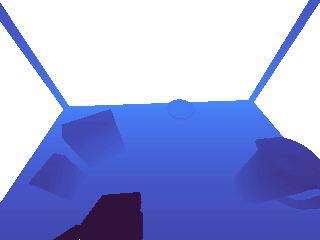

In [16]:
b.get_depth_image(rgbd_original.depth)

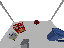

In [17]:
scaling_factor = 0.2
rgbd_scaled_down = b.RGBD.scale_rgbd(rgbd_original, scaling_factor)
b.get_rgb_image(rgbd_scaled_down.rgb)

In [18]:
b.clear_visualizer()
b.show_cloud("1", b.unproject_depth(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics).reshape(-1,3))

In [19]:
b.setup_renderer(rgbd_scaled_down.intrinsics)

Increasing frame buffer size to (width, height, depth) = (64, 64, 1024)


[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


In [20]:
os.path.join(os.path.abspath(''), 'bayes3d/assets/bop/ycbv/models')

'/home/georgematheos/bayes3d_genjax/bayes3d/assets/bop/ycbv/models'

In [21]:
model_dir = os.path.join(os.path.abspath(''), 'bayes3d/assets/bop/ycbv/models')# os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
mesh_path = os.path.join(model_dir,"obj_" + "{}".format(13+1).rjust(6, '0') + ".ply")
ycb_filenames = glob.glob(os.path.join(model_dir, "*.ply"))
ycb_index_order = [int(s.split("/")[-1].split("_")[-1].split(".")[0]) for s in ycb_filenames]
sorted_ycb_filenames = [s for _,s in sorted(zip(ycb_index_order, ycb_filenames))]
sorted_ycb_filenames

['/home/georgematheos/bayes3d_genjax/bayes3d/assets/bop/ycbv/models/obj_000001.ply',
 '/home/georgematheos/bayes3d_genjax/bayes3d/assets/bop/ycbv/models/obj_000002.ply',
 '/home/georgematheos/bayes3d_genjax/bayes3d/assets/bop/ycbv/models/obj_000003.ply',
 '/home/georgematheos/bayes3d_genjax/bayes3d/assets/bop/ycbv/models/obj_000004.ply',
 '/home/georgematheos/bayes3d_genjax/bayes3d/assets/bop/ycbv/models/obj_000005.ply',
 '/home/georgematheos/bayes3d_genjax/bayes3d/assets/bop/ycbv/models/obj_000006.ply',
 '/home/georgematheos/bayes3d_genjax/bayes3d/assets/bop/ycbv/models/obj_000007.ply',
 '/home/georgematheos/bayes3d_genjax/bayes3d/assets/bop/ycbv/models/obj_000008.ply',
 '/home/georgematheos/bayes3d_genjax/bayes3d/assets/bop/ycbv/models/obj_000009.ply',
 '/home/georgematheos/bayes3d_genjax/bayes3d/assets/bop/ycbv/models/obj_000010.ply',
 '/home/georgematheos/bayes3d_genjax/bayes3d/assets/bop/ycbv/models/obj_000011.ply',
 '/home/georgematheos/bayes3d_genjax/bayes3d/assets/bop/ycbv/mode

In [22]:
categories_on_table

['cracker_box', 'sugar_box', 'pitcher_base', 'bowl', 'foam_brick']

In [23]:
relevant_objects = [any(x in name for x in categories_on_table) for (i, name) in enumerate(b.utils.ycb_loader.MODEL_NAMES)]
relevant_object_names = [b.utils.ycb_loader.MODEL_NAMES[i] for i in range(len(b.utils.ycb_loader.MODEL_NAMES)) if relevant_objects[i]]
filtered_filenames = [sorted_ycb_filenames[i] for i in range(len(sorted_ycb_filenames)) if relevant_objects[i]]
(filtered_filenames, relevant_object_names)

(['/home/georgematheos/bayes3d_genjax/bayes3d/assets/bop/ycbv/models/obj_000002.ply',
  '/home/georgematheos/bayes3d_genjax/bayes3d/assets/bop/ycbv/models/obj_000003.ply',
  '/home/georgematheos/bayes3d_genjax/bayes3d/assets/bop/ycbv/models/obj_000011.ply',
  '/home/georgematheos/bayes3d_genjax/bayes3d/assets/bop/ycbv/models/obj_000013.ply',
  '/home/georgematheos/bayes3d_genjax/bayes3d/assets/bop/ycbv/models/obj_000021.ply'],
 ['003_cracker_box',
  '004_sugar_box',
  '019_pitcher_base',
  '024_bowl',
  '061_foam_brick'])

In [24]:
table_dims = table_info[1:]
table_mesh = b.utils.make_cuboid_mesh(table_dims)
b.RENDERER.add_mesh(table_mesh, "table")

pillar_mesh = b.utils.make_cuboid_mesh(jnp.array([0.02, 0.02, 0.5]))
b.RENDERER.add_mesh(pillar_mesh, "pillar")

for model_path in filtered_filenames:
    b.RENDERER.add_mesh_from_file(model_path, scaling_factor=1.0/1000.0)

In [25]:
len(b.RENDERER.meshes)

7

In [26]:
b.RENDERER.model_box_dims

Array([[0.75      , 1.22      , 0.03      ],
       [0.02      , 0.02      , 0.5       ],
       [0.07173   , 0.16397701, 0.21348599],
       [0.049544  , 0.09404799, 0.176015  ],
       [0.148997  , 0.144769  , 0.24264   ],
       [0.161444  , 0.16111301, 0.05497   ],
       [0.05263   , 0.077842  , 0.051131  ]], dtype=float32)

In [28]:
from src.model import model

In [29]:
obs_img = b.unproject_depth_jit(rgbd_scaled_down.depth, rgbd_scaled_down.intrinsics)


In [30]:
importance_jit = jax.jit(model.importance)

In [31]:
key = jax.random.PRNGKey(0)
trace, weight = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "id_0": jnp.int32(0),
    "camera_pose": jnp.eye(4),
    "root_pose_0": X_CT,
    "face_parent_1": 2,
    "face_child_1": 3,
    "image": obs_img,
    "variance": 0.02,
    "outlier_prob": 0.0001,
    "contact_params_1": jnp.array([0.0, 0.0, 0.0])
}), (
    jnp.arange(1),
    jnp.arange(5),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-12.0, -12.0, -jnp.pi]), jnp.array([12.0, 12.0, jnp.pi])]),
    b.RENDERER.model_box_dims
))

In [32]:
from src.model import viz_trace_meshcat
viz_trace_meshcat(trace)

In [33]:
console = genjax.console(enforce_checkify=True, width=60)

In [34]:
from src.inference import add_object

In [35]:
# id = 2: cracker box
tr2 = add_object(trace, key, 2, 0, 2, 3)

In [ ]:
viz_trace_meshcat(tr2)

In [ ]:
from src.inference import make_enumerator

In [ ]:
e = make_enumerator(["contact_params_1"])

In [ ]:
e._asdict().keys()

dict_keys(['update_choices', 'update_choices_with_weight', 'update_choices_get_score', 'enumerate_choices', 'enumerate_choices_with_weights', 'enumerate_choices_get_scores'])

In [ ]:
table_info

(((0.475, 0.0, -0.015), (0.0, 0.0, 0.0, 1.0)), 0.75, 1.22, 0.03)

In [ ]:
grid_params = [
    (0.65, jnp.pi, (30,30,15)),
    (0.2, jnp.pi, (15,15,15)),
    (0.1, jnp.pi, (15,15,15)),
    (0.05, jnp.pi/3, (15,15,15)),
    # (0.02, jnp.pi, (9,9,51)),
    # (0.01, jnp.pi/5, (15,15,15)),
    # (0.01, 0.0, (31,31,1)),
    # (0.05, 0.0, (31,31,1))
]
contact_param_gridding_schedule = [
    b.utils.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

In [ ]:
def _c2f(key, tr, object_idx, contact_param_gridding_schedule):
    address = f"contact_params_{object_idx}"
    print(address)
    updater = jax.vmap(lambda trace, v: trace.update(
        key, genjax.choice_map({address: v})
    )[0].get_score(), in_axes=(None, 0))
    cp = tr[address]
    for cp_grid in contact_param_gridding_schedule:
        cps = cp + cp_grid
        scores = updater(tr, cps)
        # key, _ = jax.random.split(key)
        # i = jax.random.randint(key, (), 0, len(cp_grid) - 1)
        cp = cps[scores.argmax()]
        # cp = cps[i]
    potential_trace = tr.update(key, genjax.choice_map({address: cp}))[0]
    return potential_trace
    

c2f = jax.jit(_c2f, static_argnums=[2])

In [ ]:
tr = tr2

address = f"contact_params_1"
cp = tr2[address]
cp_grid = contact_param_gridding_schedule[0]


updater = jax.vmap(lambda trace, v: trace.update(
        key, genjax.choice_map({address: v})
    )[0].get_score(), in_axes=(None, 0))

cps = cp + cp_grid
scores = updater(tr, cps)

print(scores)

print(scores.max(), scores.min())

print(cps)

print(cps[scores.argmax()])



[-47.957687 -47.957687 -47.957687 ... -47.957687 -47.957687 -47.957687]
-47.632164 -50.415367
[[-0.5       -0.5       -3.1415927]
 [-0.5       -0.5       -2.6927936]
 [-0.5       -0.5       -2.243995 ]
 ...
 [ 0.5        0.5        2.2439952]
 [ 0.5        0.5        2.692794 ]
 [ 0.5        0.5        3.1415927]]
[0.08620691 0.25862068 2.692794  ]


In [ ]:
cp = cps[0]
get_pose = lambda cp: tr.update(key, genjax.choice_map({address: cp}))[0].get_retval().poses[1]
get_pose_jit = jax.jit(get_pose)
poses = [get_pose_jit(cp) for cp in cps]
# tr_ = tr.update(key, genjax.choice_map({address: cp}))[0]
# tr_.get_retval().poses[1]

In [ ]:
b.clear_visualizer()

In [ ]:
cp = cps[scores.argmax()]
viz_trace_meshcat(tr.update(key, genjax.choice_map({address: cp}))[0])
b.show_pose("chosen", get_pose_jit(cp))

In [ ]:
viz_trace_meshcat(trace)

In [ ]:
for (i, pose) in enumerate(poses):
    if i % 15 == 0:
        b.show_pose(f"pose{i}", pose)

In [ ]:
b.show_pose("pose", tr_.get_retval().poses[1])

In [ ]:
# tr2.update(key, genjax.choice_map({address: cp_grid[0]}))[0]

# key, _ = jax.random.split(key)
# newtr = c2f(key, tr2, 1, contact_param_gridding_schedule)

viz_trace_meshcat(newtr)

In [ ]:
# console.print(newtr.get_choices())
newtr["contact_params_1"]

Array([ 0.06724137,  0.29137927, -0.44879878], dtype=float32)

In [ ]:
newtr = c2f(key, tr2, 1, contact_param_gridding_schedule)

contact_params_1


In [ ]:
viz_trace_meshcat(newtr)